# Connect and Extract Data from SQL Server

In [1]:
import pypyodbc as odbc #!pip install pypyodbc
import pandas as pd
import numpy as np
import time
import os

print(odbc.drivers())

['SQL Server', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'ODBC Driver 17 for SQL Server', 'SQL Server Native Client RDA 11.0', 'SQL Server Native Client RDA 11.0']


In [2]:
driverName = "SQL Server" 
serverName = "DESKTOP-UVMKETP\SQLEXPRESS"
dataBaseName = "SQL_PowerBI_Test"
username = "jvenncpe"
pwd = "#Juv1994*"

dv = "------------------------------"

In [3]:
def updateSQL():
    try:
        conn.commit()
        return print("SQL Updated Successfully!")
        
    except Exception as e:
        return print(f"Error occurred: {e}")

In [4]:
def createFreightQuery():
    freight_query = f"""
    WITH
    CLEAN_products_category_items AS
    (
    SELECT 
        REPLACE(t1.product_id,'"','') AS product_id
        , t1.product_height_cm
        , t1.product_length_cm
        , t1.product_weight_g
        , t1.product_width_cm
        , t3.freight_value
        , t3.price
        , t3.[ï»¿order_id]
    FROM
        SQL_PowerBI_Test.dbo.olist_products_dataset AS t1
    
    LEFT JOIN [product_category_name_translation] AS t2 ON t1.product_category_name = t2.[ï»¿product_category_name]
    LEFT JOIN [olist_order_items_dataset] AS t3 ON t1.product_id = t3.product_id
    ),
    
    CLEAN_orders_customers_dataset AS
    (
    SELECT
        t1.[order_id]
        , t1.[customer_id]
        , t2.customer_city
        , t2.customer_state
        , t2.customer_zip_code_prefix
    FROM [SQL_PowerBI_Test].[dbo].[olist_orders_dataset] as t1
    
    LEFT JOIN [olist_customers_dataset] AS t2 ON t1.customer_id = t2.customer_id
    ),
    
    MERGE_allNeeded AS
    (
    SELECT
        *
    FROM CLEAN_products_category_items AS t1
    LEFT JOIN CLEAN_orders_customers_dataset AS t2 ON t1.[ï»¿order_id] = t2.order_id
    )
    
    SELECT * FROM MERGE_allNeeded

    """
    return freight_query

In [5]:
connection_string = f"""
    DRIVER={{{driverName}}};
    SERVER={serverName};
    DATABASE={dataBaseName};
    Trust_Connection=yes;
    UID={username};
    PWD={pwd};
"""
try:
    conn = odbc.connect(connection_string)
    cursor = conn.cursor()
    print("Connection successful!")

except Exception as e:
    print(f"Error: {e}")

Connection successful!


In [6]:
cursor = conn.cursor()

try:
    with cursor:
        cursor.execute(createFreightQuery())
        freight_query = cursor.fetchall()
except Exception as e:
    print(e)
    conn.rollback()
    print('Transaction rollback')
finally:
    if conn is not None:
        conn.close()

In [7]:
df_freight = pd.DataFrame(freight_query)
display(df_freight)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,00066f42aeeb9f3007548bb9d3f33c38,16,20,300,16,None,None,None,None,None,None,None,None
1,00088930e925c41fd95ebfe695fd2655,10,55,1225,26,None,None,None,None,None,None,None,None
2,0009406fd7479715e4bef61dd91f2462,15,45,300,35,None,None,None,None,None,None,None,None
3,000b8f95fcb9e0096488278317764d19,24,19,550,12,None,None,None,None,None,None,None,None
4,000d9be29b5207b54e86aa1b1ac54872,11,22,250,15,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62693,bee2e070c39f3dd2f6883a17a5f0da45,20,20,175,20,48.14\r,180,fff8287bbae429a99bb7e8c21d151c41,fff8287bbae429a99bb7e8c21d151c41,6c1e92a209dbf868706caa831090941e,joao pessoa,PB,58075
62694,bee2e070c39f3dd2f6883a17a5f0da45,20,20,175,20,48.14\r,180,fff8287bbae429a99bb7e8c21d151c41,fff8287bbae429a99bb7e8c21d151c41,6c1e92a209dbf868706caa831090941e,joao pessoa,PB,58075
62695,bbe7651fef80287a816ead73f065fc4b,15,60,2700,15,44.02\r,229.9,fffa82886406ccf10c7b4e35c4ff2788,fffa82886406ccf10c7b4e35c4ff2788,a5201e1a6d71a8d21e869151bd5b4085,tenente ananias,RN,59955
62696,e7be84ea9462aac5e2b0b08eb35ba7f1,16,60,100,11,10.96\r,4.9,fffb0b1a50e65c449020434fa835e078,fffb0b1a50e65c449020434fa835e078,46b385c6d972b73cbcf797a8b16c072d,campinas,SP,13083


# Data Exploration, Cleaning and Analysis

In [8]:
replace_columnNames = \
["Product Id",
"Product Height (cm)",
"Product Length (cm)",
"Product Weight (g)",
"Product Width (cm)",
"Freight Value",
"Price ($)",
"Order ID",
"Order ID",
"Customer ID",
"Customer City",
"Customer State",
"Customer Zip Code Prefix"]

df_freight.columns = replace_columnNames
df_freight.columns

Index(['Product Id', 'Product Height (cm)', 'Product Length (cm)',
       'Product Weight (g)', 'Product Width (cm)', 'Freight Value',
       'Price ($)', 'Order ID', 'Order ID', 'Customer ID', 'Customer City',
       'Customer State', 'Customer Zip Code Prefix'],
      dtype='object')

In [9]:
df_freight.isnull().sum()

Product Id                      0
Product Height (cm)             2
Product Length (cm)             2
Product Weight (g)              2
Product Width (cm)              2
Freight Value               20568
Price ($)                   20568
Order ID                    20568
Order ID                    20568
Customer ID                 20568
Customer City               20568
Customer State              20568
Customer Zip Code Prefix    20568
dtype: int64

In [10]:
df_freight_null = df_freight.dropna(subset = ["Freight Value"])

In [11]:
df_freight_null.isnull().sum()

Product Id                  0
Product Height (cm)         0
Product Length (cm)         0
Product Weight (g)          0
Product Width (cm)          0
Freight Value               0
Price ($)                   0
Order ID                    0
Order ID                    0
Customer ID                 0
Customer City               0
Customer State              0
Customer Zip Code Prefix    0
dtype: int64

# -----------------------------------------------------------------------------------------

In [12]:
df_freight_null_columndrop = df_freight_null.drop(columns = \
["Product Id",
"Order ID",
"Order ID",
"Customer ID"])

In [13]:
df_freight_null_columndrop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42130 entries, 20568 to 62697
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Product Height (cm)       42130 non-null  object
 1   Product Length (cm)       42130 non-null  object
 2   Product Weight (g)        42130 non-null  object
 3   Product Width (cm)        42130 non-null  object
 4   Freight Value             42130 non-null  object
 5   Price ($)                 42130 non-null  object
 6   Customer City             42130 non-null  object
 7   Customer State            42130 non-null  object
 8   Customer Zip Code Prefix  42130 non-null  object
dtypes: object(9)
memory usage: 3.2+ MB


In [14]:
df_freight_null_columndrop.columns

Index(['Product Height (cm)', 'Product Length (cm)', 'Product Weight (g)',
       'Product Width (cm)', 'Freight Value', 'Price ($)', 'Customer City',
       'Customer State', 'Customer Zip Code Prefix'],
      dtype='object')

In [15]:
numeric_columns = ['Product Height (cm)', 'Product Length (cm)', 'Product Weight (g)',
       'Product Width (cm)', 'Freight Value', 'Price ($)']

In [16]:
for column in numeric_columns:
    print(column)
    df_freight_null_columndrop[column] = pd.to_numeric(df_freight_null_columndrop[column], errors='coerce')

Product Height (cm)
Product Length (cm)
Product Weight (g)
Product Width (cm)
Freight Value
Price ($)


In [17]:
df_freight_null_columndrop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42130 entries, 20568 to 62697
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Product Height (cm)       42130 non-null  int64  
 1   Product Length (cm)       42130 non-null  int64  
 2   Product Weight (g)        42130 non-null  int64  
 3   Product Width (cm)        42130 non-null  int64  
 4   Freight Value             42130 non-null  float64
 5   Price ($)                 42130 non-null  float64
 6   Customer City             42130 non-null  object 
 7   Customer State            42130 non-null  object 
 8   Customer Zip Code Prefix  42130 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 3.2+ MB


In [18]:
df_freight_null_columndrop.head(5)

,Product Height (cm),Product Length (cm),Product Weight (g),Product Width (cm),Freight Value,Price ($),Customer City,Customer State,Customer Zip Code Prefix
20568,30,50,30000,40,19.93,239.90,santa fe do sul,SP,15775
20569,13,33,3050,33,17.87,199.00,para de minas,MG,35661
20570,40,35,3750,30,18.14,199.90,varzea paulista,SP,13226
20571,8,24,450,15,12.69,21.90,uberaba,MG,38017
20572,25,35,950,20,8.88,59.99,piracicaba,SP,13419


In [19]:
target_mean_customercity = df_freight_null_columndrop.groupby('Customer City')['Freight Value'].mean().to_dict()
target_mean_customerstate = df_freight_null_columndrop.groupby('Customer State')['Freight Value'].mean().to_dict()
target_mean_customerzip = df_freight_null_columndrop.groupby('Customer Zip Code Prefix')['Freight Value'].mean().to_dict()

In [20]:
df_freight_null_columndrop['Customer City'] = df_freight_null_columndrop['Customer City'].map(target_mean_customercity)
df_freight_null_columndrop['Customer State'] = df_freight_null_columndrop['Customer State'].map(target_mean_customerstate)
df_freight_null_columndrop['Customer Zip Code Prefix'] = df_freight_null_columndrop['Customer Zip Code Prefix'].map(target_mean_customerzip)

In [21]:
df_freight_null_columndrop.head(5)

,Product Height (cm),Product Length (cm),Product Weight (g),Product Width (cm),Freight Value,Price ($),Customer City,Customer State,Customer Zip Code Prefix
20568,30,50,30000,40,19.93,239.90,18.298125,15.266044,18.298125
20569,13,33,3050,33,17.87,199.00,25.515333,20.513701,16.851000
20570,40,35,3750,30,18.14,199.90,21.682368,15.266044,18.140000
20571,8,24,450,15,12.69,21.90,20.602778,20.513701,17.536000
20572,25,35,950,20,8.88,59.99,16.651863,15.266044,14.044167


In [22]:
#Splitting and Dropping of Data & Columns for Machine Learning
from sklearn.model_selection import train_test_split

X = df_freight_null_columndrop.drop(columns = ['Freight Value'])
y = df_freight_null_columndrop['Freight Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

print(dv)
print(f'df_shape: \t {df_freight_null_columndrop.shape}')

print(dv)
print(f'X_train: \t {X_train.shape} \ny_train: \t {y_train.shape}')

print(dv)
print(f'X_test: \t {X_test.shape} \ny_test: \t {y_test.shape}')

------------------------------
df_shape: 	 (42130, 9)
------------------------------
X_train: 	 (31597, 8) 
y_train: 	 (31597,)
------------------------------
X_test: 	 (10533, 8) 
y_test: 	 (10533,)


In [23]:
validation_size = 0.15
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=10)


In [24]:
print(dv)
print(f'df_shape: \t {df_freight_null_columndrop.shape}')

print(dv)
print(f'X_validation: \t {X_validation.shape} \ny_validation: \t {y_validation.shape}')

print(dv)
print(f'X_train: \t {X_train.shape} \ny_train: \t {y_train.shape}')

print(dv)
print(f'X_test: \t {X_test.shape} \ny_test: \t {y_test.shape}')

------------------------------
df_shape: 	 (42130, 9)
------------------------------
X_validation: 	 (4740, 8) 
y_validation: 	 (4740,)
------------------------------
X_train: 	 (26857, 8) 
y_train: 	 (26857,)
------------------------------
X_test: 	 (10533, 8) 
y_test: 	 (10533,)


# Cross Validation, Grid Search and Modeling

## CROSS VALIDATION

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

<table>
  <tr>
    <th colspan="2">Regression Models to Cross-Validate</th>
  </tr>
  <tr>
    <td>Linear Regression</td>
    <td>K-Nearest Neighbors Regression (KNN)</td>
  </tr>
  <tr>
    <td>Lasso Regression</td>
    <td>Decision Tree Regression</td>
  </tr>
  <tr>
    <td>Ridge Regression</td>
    <td>XGBoost Regression</td>
  </tr>
  <tr>
    <td>Gradient Boosting Regression</td>
    <td></td>
  </tr>
  <tr>
    <td>Random Forest Regression</td>
    <td></td>
  </tr>
  <tr>
    <td>Support Vector Regression (SVR)</td>
    <td></td>
  </tr>
</table>


In [26]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge(),
    'KNN Regression': KNeighborsRegressor(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'SVR': SVR(),
    'XGBoost Regression': XGBRegressor(),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    'Random Forest Regression': RandomForestRegressor()
}

# Loop over each model
for name, model in models.items():
    # Perform cross-validation with different scoring options
    cv_scores_mse = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores_mae = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    cv_scores_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_scores_explained_variance = cross_val_score(model, X_train, y_train, cv=5, scoring='explained_variance')
    
    # Calculate mean scores
    mean_mse = -cv_scores_mse.mean()
    mean_mae = -cv_scores_mae.mean()
    mean_r2 = cv_scores_r2.mean()
    mean_explained_variance = cv_scores_explained_variance.mean()
    
    # Print the mean scores for each model
    print(dv)
    print(f"Model: {name}")
    print(f"MSE Mean: {mean_mse:.2f}")
    print(f"MAE Mean: {mean_mae:.2f}")
    print(f"R2 Mean: {mean_r2:.2f}")
    print(f"Explained Variance Mean: {mean_explained_variance:.2f}\n")


------------------------------
Model: Linear Regression
MSE Mean: 86.16
MAE Mean: 5.13
R2 Mean: 0.66
Explained Variance Mean: 0.66

------------------------------
Model: Lasso Regression
MSE Mean: 86.21
MAE Mean: 5.11
R2 Mean: 0.66
Explained Variance Mean: 0.66

------------------------------
Model: Ridge Regression
MSE Mean: 86.16
MAE Mean: 5.13
R2 Mean: 0.66
Explained Variance Mean: 0.66

------------------------------
Model: KNN Regression
MSE Mean: 104.44
MAE Mean: 5.09
R2 Mean: 0.59
Explained Variance Mean: 0.59

------------------------------
Model: Decision Tree Regression
MSE Mean: 125.16
MAE Mean: 5.28
R2 Mean: 0.50
Explained Variance Mean: 0.50

------------------------------
Model: SVR
MSE Mean: 161.40
MAE Mean: 6.44
R2 Mean: 0.36
Explained Variance Mean: 0.38

------------------------------
Model: XGBoost Regression
MSE Mean: 66.79
MAE Mean: 4.18
R2 Mean: 0.73
Explained Variance Mean: 0.73

------------------------------
Model: Gradient Boosting Regression
MSE Mean: 71.62
M

<table border="1">
    <tr>
      <th>Model</th>
      <th>MSE Mean</th>
      <th>MAE Mean</th>
      <th>R2 Mean</th>
      <th>Explained Variance Mean</th>
    </tr>
    <tr>
      <td>XGBoost Regression</td>
      <td>66.79</td>
      <td>4.18</td>
      <td>0.73</td>
      <td>0.73</td>
    </tr>
    <tr>
      <td>Gradient Boosting Regression</td>
      <td>71.45</td>
      <td>4.50</td>
      <td>0.72</td>
      <td>0.71</td>
    </tr>
    <tr>
      <td>Random Forest Regression</td>
      <td>65.80</td>
      <td>3.95</td>
      <td>0.74</td>
      <td>0.74</td>
    </tr>
  </table>

## HYPERPARAMETER TUNING

In [27]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# Initialize variables to keep track of the best score and corresponding parameters
best_score_xgb = 0
best_params_xgb = None
best_score_gb = 0
best_params_gb = None
best_score_rf = 0
best_params_rf = None

# Define the hyperparameter grids for each model
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
}

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
}

for n_estimators in param_grid_xgb['n_estimators']:
    for max_depth in param_grid_xgb['max_depth']:
        regr = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth)
        regr.fit(X_train,y_train)
        score = regr.score(X_validation,y_validation)

        if score > best_score_xgb:
            best_score_xgb = score
            best_params_xgb = {'n_estimators':n_estimators, 'max_depth':max_depth}
print("""XGBoost Regression
Best Score: {:.2f}
Best Parameters: {}
""".format(best_score_xgb, best_params_xgb))
        
for n_estimators in param_grid_gb['n_estimators']:
    for max_depth in param_grid_gb['max_depth']:
        regr = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth)
        regr.fit(X_train,y_train)
        score = regr.score(X_validation,y_validation)

        if score > best_score_gb:
            best_score_gb = score
            best_params_gb = {'n_estimators':n_estimators, 'max_depth':max_depth}
print("""Gradient Boosting Regression
Best Score: {:.2f}
Best Parameters: {}
""".format(best_score_gb, best_params_gb))

for n_estimators in param_grid_rf['n_estimators']:
    for max_depth in param_grid_rf['max_depth']:
        regr = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        regr.fit(X_train,y_train)
        score = regr.score(X_validation,y_validation)

        if score > best_score_rf:
            best_score_rf = score
            best_params_rf = {'n_estimators':n_estimators, 'max_depth':max_depth}
print("""Random Forest Regression
Best Score: {:.2f}
Best Parameters: {}
""".format(best_score_rf, best_params_rf))





XGBoost Regression
Best Score: 0.77
Best Parameters: {'n_estimators': 300, 'max_depth': 4}

Gradient Boosting Regression
Best Score: 0.78
Best Parameters: {'n_estimators': 300, 'max_depth': 5}

Random Forest Regression
Best Score: 0.70
Best Parameters: {'n_estimators': 200, 'max_depth': 5}



## REGRESSION MODELING

### XGBoost Regression

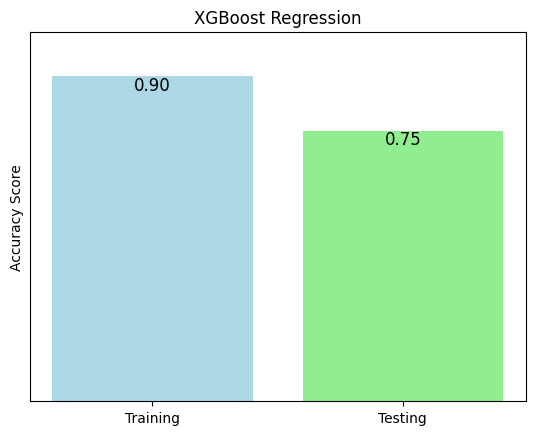

In [31]:
import matplotlib.pyplot as plt

xgb_reg = XGBRegressor(n_estimators=300, max_depth=4)
xgb_reg.fit(X_train,y_train)

# Calculate the accuracy scores for the training and test sets
xgb_train_score = xgb_reg.score(X_train, y_train)
xgb_test_score = xgb_reg.score(X_test, y_test)

# Model scores
scores = [xgb_train_score, xgb_test_score]
labels = ['Training', 'Testing']

# Create the column chart
plt.bar(labels, scores, color=['lightblue', 'lightgreen'])
plt.ylabel('Accuracy Score')
plt.title('XGBoost Regression')
plt.yticks([])
plt.ylim(0, 1.02)

# Display the scores on the columns
for i, score in enumerate(scores):
    plt.text(i, score, f'{score:.2f}', ha='center', va='top', fontsize=12, color='black')

plt.show()

### Gradient Boosting Regression

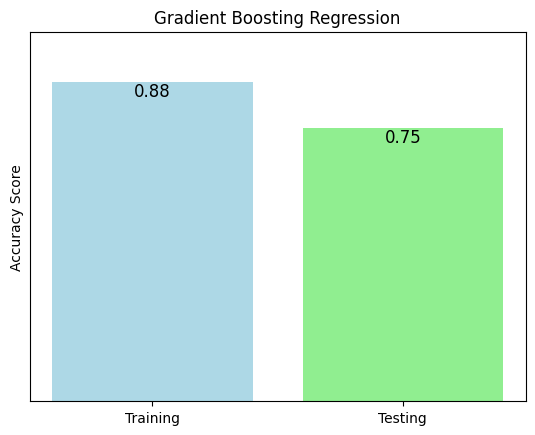

In [32]:
gb_reg = GradientBoostingRegressor(n_estimators=200, max_depth=5)
gb_reg.fit(X_train,y_train)

# Calculate the accuracy scores for the training and test sets
gb_train_score = gb_reg.score(X_train, y_train)
gb_test_score = gb_reg.score(X_test, y_test)

# Model scores
scores = [gb_train_score, gb_test_score]
labels = ['Training', 'Testing']

# Create the column chart
plt.bar(labels, scores, color=['lightblue', 'lightgreen'])
plt.ylabel('Accuracy Score')
plt.title('Gradient Boosting Regression')
plt.yticks([])
plt.ylim(0, 1.02)

# Display the scores on the columns
for i, score in enumerate(scores):
    plt.text(i, score, f'{score:.2f}', ha='center', va='top', fontsize=12, color='black')

plt.show()

### Random Forest Regression

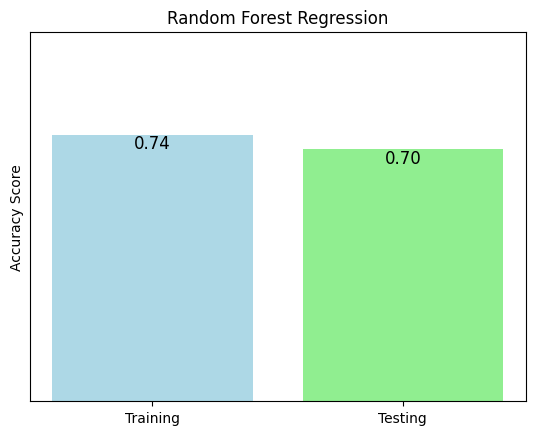

In [33]:
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=5)
rf_reg.fit(X_train,y_train)

# Calculate the accuracy scores for the training and test sets
rf_train_score = rf_reg.score(X_train, y_train)
rf_test_score = rf_reg.score(X_test, y_test)

# Model scores
scores = [rf_train_score, rf_test_score]
labels = ['Training', 'Testing']

# Create the column chart
plt.bar(labels, scores, color=['lightblue', 'lightgreen'])
plt.ylabel('Accuracy Score')
plt.title('Random Forest Regression')
plt.yticks([])
plt.ylim(0, 1.02)

# Display the scores on the columns
for i, score in enumerate(scores):
    plt.text(i, score, f'{score:.2f}', ha='center', va='top', fontsize=12, color='black')

plt.show()

# Evaluation Metrics - MSE, MAE, R2 & Explained Variance

## MEAN SQUARED ERROR (MSE)

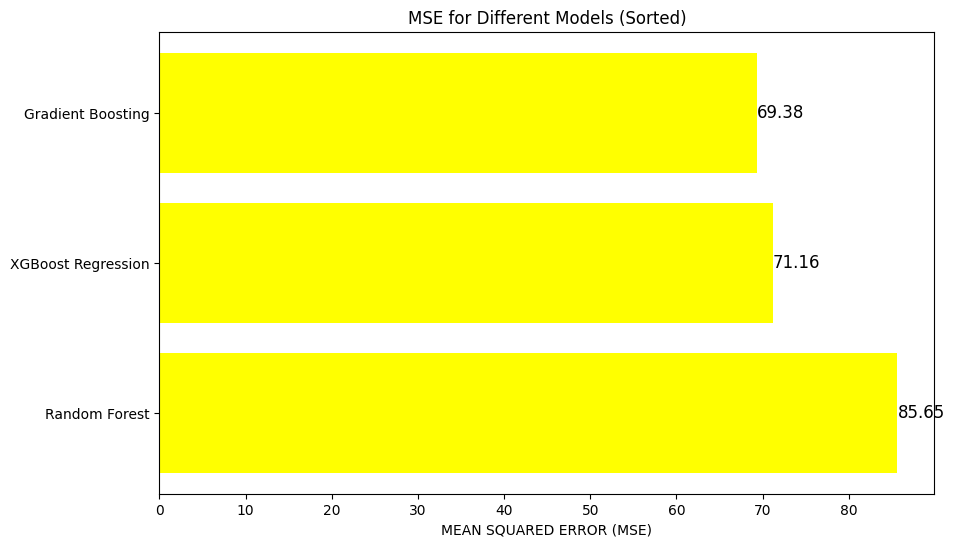

In [34]:
mse_XGB = mean_squared_error(y_test, xgb_reg.predict(X_test))
mse_GB = mean_squared_error(y_test, gb_reg.predict(X_test))
mse_RF = mean_squared_error(y_test, rf_reg.predict(X_test))

# Find the model with the highest ROC-AUC score
model = np.array([
    ['XGBoost Regression', mse_XGB],
    ['Gradient Boosting', mse_GB],
    ['Random Forest', mse_RF],

])

# Extract model names and accuracy scores
model_names = model[:, 0]
accuracy_scores = model[:, 1].astype(float)

# Sort the data based on accuracy scores in descending order
sorted_indices = np.argsort(accuracy_scores)[::-1]
model_names = model_names[sorted_indices]
accuracy_scores = accuracy_scores[sorted_indices]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracy_scores, color= 'Yellow')
plt.xlabel('MEAN SQUARED ERROR (MSE)')
plt.title('MSE for Different Models (Sorted)')
plt.grid(axis='x', linestyle=' ', alpha=0.6)

# Display the accuracy scores on the bars
for i, accuracy in enumerate(accuracy_scores):
    plt.text(accuracy, i, f'{accuracy:.2f}', va='center', fontsize=12, color='black')

plt.show()


## MEAN ABSOLUTE ERROR (MAE)

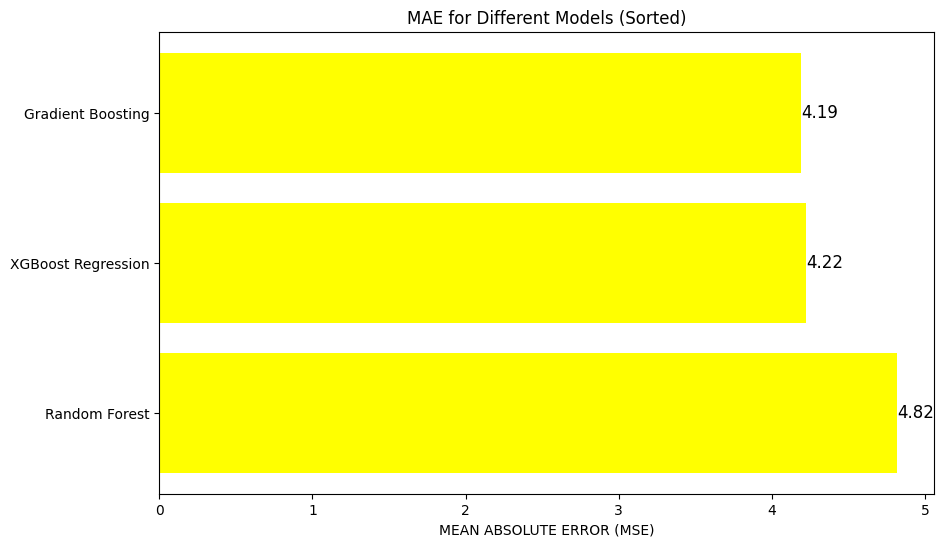

In [35]:
mae_XGB = mean_absolute_error(y_test, xgb_reg.predict(X_test))
mae_GB = mean_absolute_error(y_test, gb_reg.predict(X_test))
mae_RF = mean_absolute_error(y_test, rf_reg.predict(X_test))

# Find the model with the highest ROC-AUC score
model = np.array([
    ['XGBoost Regression', mae_XGB],
    ['Gradient Boosting', mae_GB],
    ['Random Forest', mae_RF],

])

# Extract model names and accuracy scores
model_names = model[:, 0]
accuracy_scores = model[:, 1].astype(float)

# Sort the data based on accuracy scores in descending order
sorted_indices = np.argsort(accuracy_scores)[::-1]
model_names = model_names[sorted_indices]
accuracy_scores = accuracy_scores[sorted_indices]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracy_scores, color= 'Yellow')
plt.xlabel('MEAN ABSOLUTE ERROR (MSE)')
plt.title('MAE for Different Models (Sorted)')
plt.grid(axis='x', linestyle=' ', alpha=0.6)

# Display the accuracy scores on the bars
for i, accuracy in enumerate(accuracy_scores):
    plt.text(accuracy, i, f'{accuracy:.2f}', va='center', fontsize=12, color='black')

plt.show()


## R-SQUARED (R2)

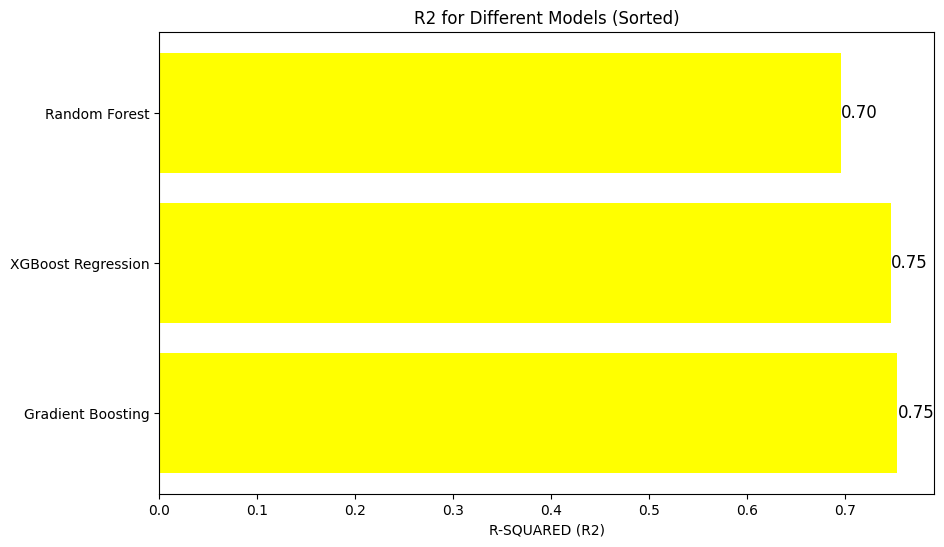

In [36]:
r2_XGB = r2_score(y_test, xgb_reg.predict(X_test))
r2_GB = r2_score(y_test, gb_reg.predict(X_test))
r2_RF = r2_score(y_test, rf_reg.predict(X_test))

# Find the model with the highest ROC-AUC score
model = np.array([
    ['XGBoost Regression', r2_XGB],
    ['Gradient Boosting', r2_GB],
    ['Random Forest', r2_RF],

])

# Extract model names and accuracy scores
model_names = model[:, 0]
accuracy_scores = model[:, 1].astype(float)

# Sort the data based on accuracy scores in descending order
sorted_indices = np.argsort(accuracy_scores)[::-1]
model_names = model_names[sorted_indices]
accuracy_scores = accuracy_scores[sorted_indices]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracy_scores, color= 'Yellow')
plt.xlabel('R-SQUARED (R2)')
plt.title('R2 for Different Models (Sorted)')
plt.grid(axis='x', linestyle=' ', alpha=0.6)

# Display the accuracy scores on the bars
for i, accuracy in enumerate(accuracy_scores):
    plt.text(accuracy, i, f'{accuracy:.2f}', va='center', fontsize=12, color='black')

plt.show()


## EXPLAINED VARIANCE

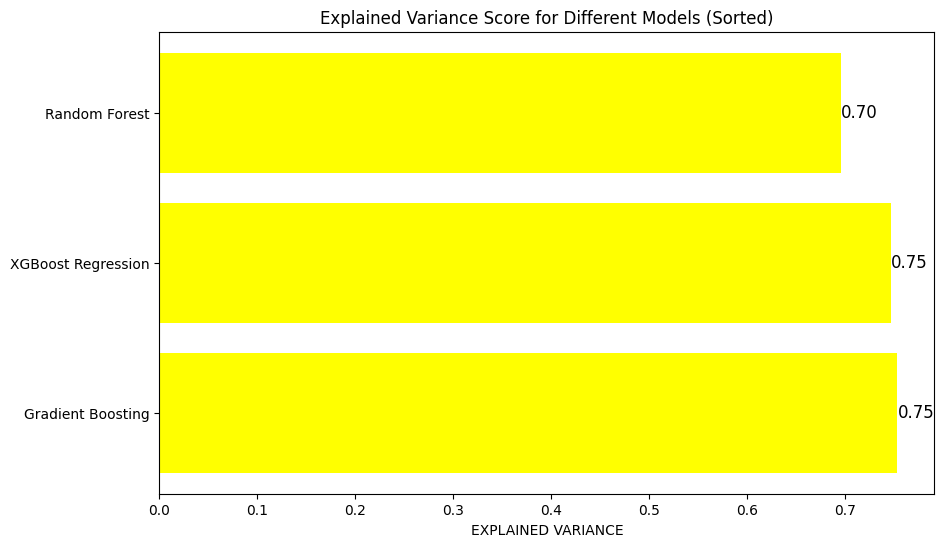

In [37]:
var_XGB = explained_variance_score(y_test, xgb_reg.predict(X_test))
var_GB = explained_variance_score(y_test, gb_reg.predict(X_test))
var_RF = explained_variance_score(y_test, rf_reg.predict(X_test))

# Find the model with the highest ROC-AUC score
model = np.array([
    ['XGBoost Regression', var_XGB],
    ['Gradient Boosting', var_GB],
    ['Random Forest', var_RF],

])

# Extract model names and accuracy scores
model_names = model[:, 0]
accuracy_scores = model[:, 1].astype(float)

# Sort the data based on accuracy scores in descending order
sorted_indices = np.argsort(accuracy_scores)[::-1]
model_names = model_names[sorted_indices]
accuracy_scores = accuracy_scores[sorted_indices]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracy_scores, color= 'Yellow')
plt.xlabel('EXPLAINED VARIANCE')
plt.title('Explained Variance Score for Different Models (Sorted)')
plt.grid(axis='x', linestyle=' ', alpha=0.6)

# Display the accuracy scores on the bars
for i, accuracy in enumerate(accuracy_scores):
    plt.text(accuracy, i, f'{accuracy:.2f}', va='center', fontsize=12, color='black')

plt.show()

# CONCLUSION

### Findings:

<p>
Upon comprehensive analysis of the evaluation metrics, it is evident that both the XGBoost and Gradient Boosting algorithms have demonstrated superior performance compared to the Random Forest model across multiple criteria.
</br></br>• XGBoost (XGB) and Gradient Boosting (GB) exhibit lower Mean Squared Error (MSE) values compared to Random Forest (RF), with XGBoost at 71.16 and Gradient Boosting at 69.28, outperforming Random Forest's 85.38.
</br></br>• In terms of Mean Absolute Error (MAE), XGBoost and Gradient Boosting also demonstrate superior performance, with XGBoost registering 4.22 and Gradient Boosting at 4.19, compared to Random Forest's 4.86.
</br></br>• Both XGBoost and Gradient Boosting achieve higher R2 scores (0.75) compared to Random Forest (0.70), indicating better overall fit of the models to the data.
</br></br>• The Explained Variance for XGBoost and Gradient Boosting stands at 0.75, while Random Forest lags behind at 0.70.
</br></br>Overall, based on the lower MSE and MAE, higher R2 score, and Explained Variance, XGBoost and Gradient Boosting models perform better compared to Random Forest. </p>